In [ ]:
import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd

from tqdm import tqdm

from sklearn.metrics import confusion_matrix


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train_set=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
test_set=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

trainloader=torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)
testloader=torch.utils.data.DataLoader(test_set,batch_size=32,shuffle=False,num_workers=2,pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))


In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
from torchsummary import summary
summary(model,(3,32,32))

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

5852234

In [ ]:
train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)

  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(trainloader):

    inputs=data[0].to(device, non_blocking=True)
    labels=data[1].to(device, non_blocking=True)

     # The following code will be called asynchronously,
    # such that the kernel will be launched and returns control
    # to the CPU thread before the kernel has actually begun executing
    # has to wait for data to be pushed onto device (synch point)

    outputs=model(inputs)

    loss=loss_fn(outputs,labels)

    #Replaces pow(2.0) with abs() for L1 regularization

    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

    loss = loss + l2_lambda * l2_norm

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total

  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [ ]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)

      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()

      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

  test_loss=running_loss/len(testloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))



In [ ]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch)
  test(epoch)


Epoch : 1


 37%|███▋      | 584/1563 [00:09<00:15, 62.20it/s]


KeyboardInterrupt: ignored

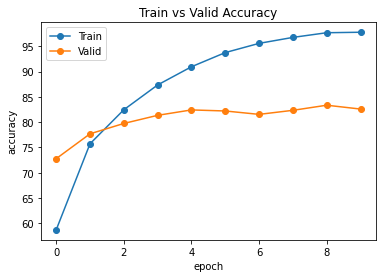

In [ ]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

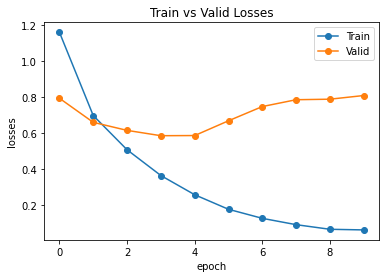

In [ ]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [ ]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:02<00:00, 105.80it/s]


In [ ]:
print(y_pred)
print(y_true)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 4, 9, 4, 7, 9, 8, 5, 7, 8, 6, 4, 0, 0, 9, 4, 4, 4, 0, 9, 6, 6, 5, 4, 5, 9, 3, 4, 9, 9, 5, 4, 6, 3, 6, 0, 9, 3, 9, 7, 2, 9, 8, 5, 3, 8, 8, 7, 5, 5, 6, 7, 5, 6, 3, 6, 2, 1, 2, 3, 7, 0, 3, 8, 8, 0, 2, 0, 3, 3, 8, 8, 1, 1, 7, 2, 9, 2, 8, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 8, 2, 9, 3, 0, 4, 6, 7, 8, 3, 1, 2, 8, 0, 8, 3, 6, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 5, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 2, 4, 2, 1, 3, 6, 0, 4, 8, 3, 5, 8, 9, 9, 9, 8, 9, 9, 3, 7, 3, 0, 0, 5, 2, 2, 3, 8, 6, 3, 3, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 3, 1, 8, 7, 1, 3, 0, 5, 7, 9, 5, 4, 5, 9, 8, 4, 7, 9, 8, 2, 7, 3, 9, 4, 3, 9, 6, 4, 3, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 9, 8, 9, 0, 2, 1, 8, 2, 2, 5, 3, 9, 9, 4, 8, 3, 0, 0, 9, 8, 1, 5, 3, 8, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 2, 0, 2, 4, 3, 9, 1, 6, 1, 0, 9, 1, 8, 7, 9, 1, 2, 6, 1, 3, 2, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 2, 8, 6, 0, 0, 4, 0, 4, 7, 5, 5, 3, 5, 2, 2, 7, 1, 7, 5, 4, 6, 1, 9, 2, 

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)


('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,852,13,28,14,17,4,4,3,43,22
car,11,879,4,3,1,3,6,1,23,69
bird,51,1,708,63,57,46,34,22,12,6
cat,15,1,57,702,44,110,33,23,9,6
deer,10,2,59,58,805,15,26,18,7,0
dog,12,2,31,152,34,723,17,26,1,2
frog,6,5,43,64,17,18,833,3,10,1
horse,11,0,15,34,60,31,2,836,4,7
ship,41,6,3,11,1,4,1,2,915,16
truck,14,33,2,6,0,0,4,3,24,914


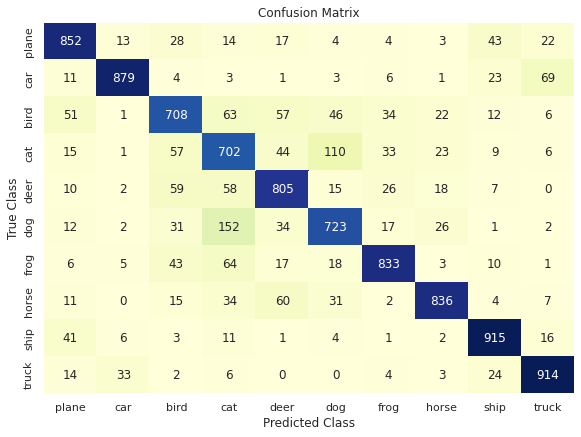

In [ ]:
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"),
plt.xlabel("Predicted Class")
plt.show()